In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('train.csv', dtype=np.float32)
targets_numpy = train.label.values 
features_numpy = train.loc[:, train.columns != 'label'].values / 255 

features_train, features_test, targets_train, targets_test = train_test_split(features_numpy, targets_numpy, test_size=0.2, random_state=42)

# for i in range(train.shape[0]): 
#     a = train.iloc[i, :].to_numpy()
#     plt.figure()
#     plt.imshow(a[1:].reshape(28, 28), cmap='gray')
#     plt.show()

In [3]:
f = train.loc[:, train.columns != 'label']
f.shape

(42000, 784)

In [4]:
features_train.shape, features_test.shape, targets_train.shape, targets_test.shape

((33600, 784), (8400, 784), (33600,), (8400,))

In [5]:
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

featuresTrain.shape, targetsTrain.shape, featuresTest.shape, targetsTest.shape

(torch.Size([33600, 784]),
 torch.Size([33600]),
 torch.Size([8400, 784]),
 torch.Size([8400]))

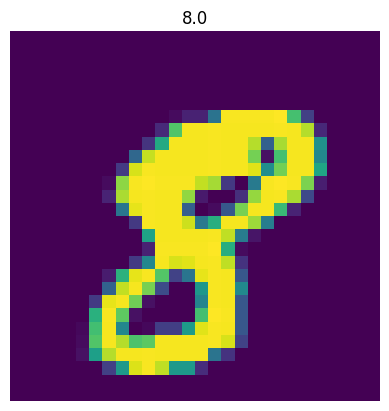

In [6]:
batch_size = 100
n_iters = 10000 
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

train = TensorDataset(featuresTrain, targetsTrain)
test = TensorDataset(featuresTest, targetsTest)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

plt.imshow(features_numpy[10].reshape(28, 28))
plt.axis('off')
plt.title(str(targets_numpy[10]))
plt.show()

In [7]:
class RNNModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.rnn = nn.RNN(28, 100, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(100, 10)

    def forward(self, x):
        out, hn = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.lstm = nn.LSTM(28, 100, batch_first=True)
        self.fc = nn.Linear(100, 10)
    
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [8]:
rnn =  nn.RNN(28, 100, batch_first=True, nonlinearity='relu')
fc = nn.Linear(100, 10)

a = torch.randn(100, 28, 28)
out, hn = rnn(a)
out2 = fc(out[:, -1, :])

print(out.shape, hn.shape, out2.shape)

lstm = nn.LSTM(28, 100, batch_first=True)

a = torch.randn(100, 28, 28)
out, (hn, cn) = lstm(a)
out2 = fc(out[:, -1, :])

print(out.shape, hn.shape, cn.shape, out2.shape)

torch.Size([100, 28, 100]) torch.Size([1, 100, 100]) torch.Size([100, 10])
torch.Size([100, 28, 100]) torch.Size([1, 100, 100]) torch.Size([1, 100, 100]) torch.Size([100, 10])


In [9]:
batch_size = 100 
n_iters = 8000 
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

train = TensorDataset(featuresTrain, targetsTrain)
test = TensorDataset(featuresTest, targetsTest)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

model2 = LSTMModel().to(device)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.05)

In [10]:
loss_list = []
iteration_list = []
accuracy_list = []
count = 0 

for epoch in range(num_epochs): 
    for i, (images, labels) in enumerate(train_loader): 
        train = images.view(-1, 28, 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(train)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        optimizer2.zero_grad()
        outputs2 = model2(train)
        loss2 = criterion2(outputs2, labels)
        loss2.backward()
        optimizer2.step()

        count += 1
        if count % 250 == 0: 
            correct = 0 
            correct2 = 0
            total = 0 

            for images, labels in test_loader: 
                images = images.view(-1, 28, 28).to(device)
                outputs = model(images)
                outputs2 = model2(images)
                _, predicted = torch.max(outputs.data, 1)
                _, predicted2 = torch.max(outputs2.data, 1)
                total += labels.size(0)
                correct += (predicted.cpu() == labels).sum().item()
                correct2 += (predicted2.cpu() == labels).sum().item()
            accuracy = 100 * correct / total
            accuracy2 = 100 * correct2 / total
            loss_list.append([loss.data.cpu().item(), loss2.data.cpu().item()])

            iteration_list.append([count, count])
            accuracy_list.append([accuracy, accuracy2])
            if count % 500 == 0:
                print('Iteration: {} Loss: {} Accuracy: {}% Loss2: {} Accuracy2: {}%'.format(count, loss.data.cpu().item(), accuracy, loss2.data.cpu().item(), accuracy2))

        # train = images.view(-1, seq_dim, input_dim)
        # labels = labels 

        # optimizer.zero_grad()
        # outputs = model(train)
        # loss = loss_fn(outputs, labels)
        # loss.backward()
        # optimizer.step()

        # count += 1
        # if count % 250 == 0: 
        #     correct = 0 
        #     total = 0 
        #     for images, labels in test_loader: 
        #         images = images.view(-1, seq_dim, input_dim)
        #         outputs = model(images)
        #         _, predicted = torch.max(outputs.data, 1)
        #         total += labels.size(0)
        #         correct += (predicted == labels).sum()
        #     accuracy = 100 * correct / total 
        #     loss_list.append(loss.data)
        #     iteration_list.append(count)
        #     accuracy_list.append(accuracy)
        #     if count % 500 == 0: 
        #         print('Iteration: {} Loss: {} Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500 Loss: 2.3011183738708496 Accuracy: 10.928571428571429% Loss2: 2.290748357772827 Accuracy2: 14.880952380952381%
Iteration: 1000 Loss: 2.3023171424865723 Accuracy: 13.452380952380953% Loss2: 2.278623104095459 Accuracy2: 19.392857142857142%
Iteration: 1500 Loss: 2.293626308441162 Accuracy: 17.904761904761905% Loss2: 1.7589280605316162 Accuracy2: 42.88095238095238%
Iteration: 2000 Loss: 2.2549991607666016 Accuracy: 19.571428571428573% Loss2: 0.7892522215843201 Accuracy2: 71.04761904761905%
Iteration: 2500 Loss: 1.9041692018508911 Accuracy: 32.51190476190476% Loss2: 0.6467970013618469 Accuracy2: 81.63095238095238%
Iteration: 3000 Loss: 0.9165761470794678 Accuracy: 68.52380952380952% Loss2: 0.2573434114456177 Accuracy2: 90.13095238095238%
Iteration: 3500 Loss: 0.8864879012107849 Accuracy: 76.0952380952381% Loss2: 0.33253997564315796 Accuracy2: 91.23809523809524%
Iteration: 4000 Loss: 0.44221922755241394 Accuracy: 77.47619047619048% Loss2: 0.05934065207839012 Accuracy2: 94.1309

In [19]:
iteration_list = np.array(iteration_list).reshape(-1, 2)
loss_list = np.array(loss_list).reshape(-1, 2)
accuracy_list = np.array(accuracy_list).reshape(-1, 2)

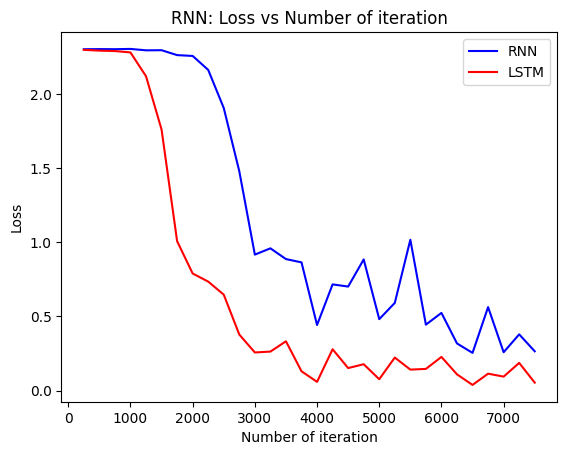

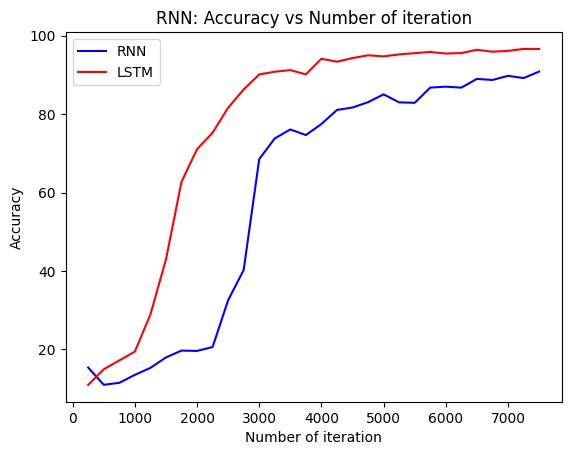

In [21]:
plt.plot(iteration_list[:, 0], loss_list[:, 0], color='blue', label='RNN')
plt.plot(iteration_list[:, 1], loss_list[:, 1], color='red', label='LSTM')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list[:, 0], accuracy_list[:, 0], color='blue', label='RNN')
plt.plot(iteration_list[:, 1], accuracy_list[:, 1], color='red', label='LSTM')
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.legend()
# plt.savefig('graph.png')
plt.show()

Text(0.5, 1.0, '5 8')

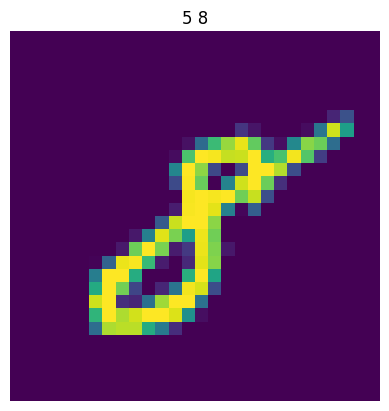

In [29]:
test = pd.read_csv('test.csv', dtype=np.float32)
test_numpy = test.values / 255
test_tensor = torch.from_numpy(test_numpy)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)

out = model(test_tensor.view(-1, 28, 28).to(device))
out2 = model2(test_tensor.view(-1, 28, 28).to(device))

_, predicted = torch.max(out.data, 1)
_, predicted2 = torch.max(out2.data, 1)

predicted = predicted.cpu().numpy()
predicted2 = predicted2.cpu().numpy()



Text(0.5, 1.0, 'RNN: 6 LSTM: 6')

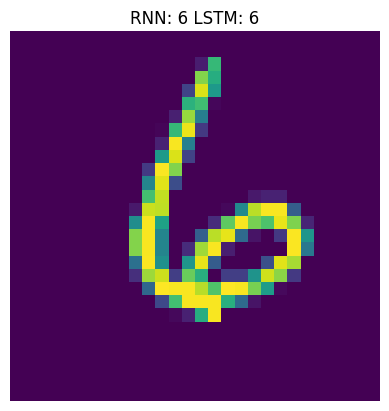

In [51]:
ind = np.random.randint(0, test_tensor.shape[0])
plt.imshow(test_numpy[ind].reshape(28, 28))
plt.axis('off')
plt.title("RNN: {}".format(predicted[ind]) + " LSTM: {}".format(predicted2[ind]))


In [53]:
out.data.shape

torch.Size([28000, 10])